In [25]:
BASE_DIR = '/kaggle/input/utkface-new/UTKFace/'

In [26]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras import initializers, layers
import keras.backend as K
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization

In [27]:
image_paths, age_labels, gender_labels = [], [], []
for filename in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

In [28]:
df = pd.DataFrame({'image': image_paths, 'age': age_labels, 'gender': gender_labels})
gender_dict = {0: 'Male', 1: 'Female'} # df.head()

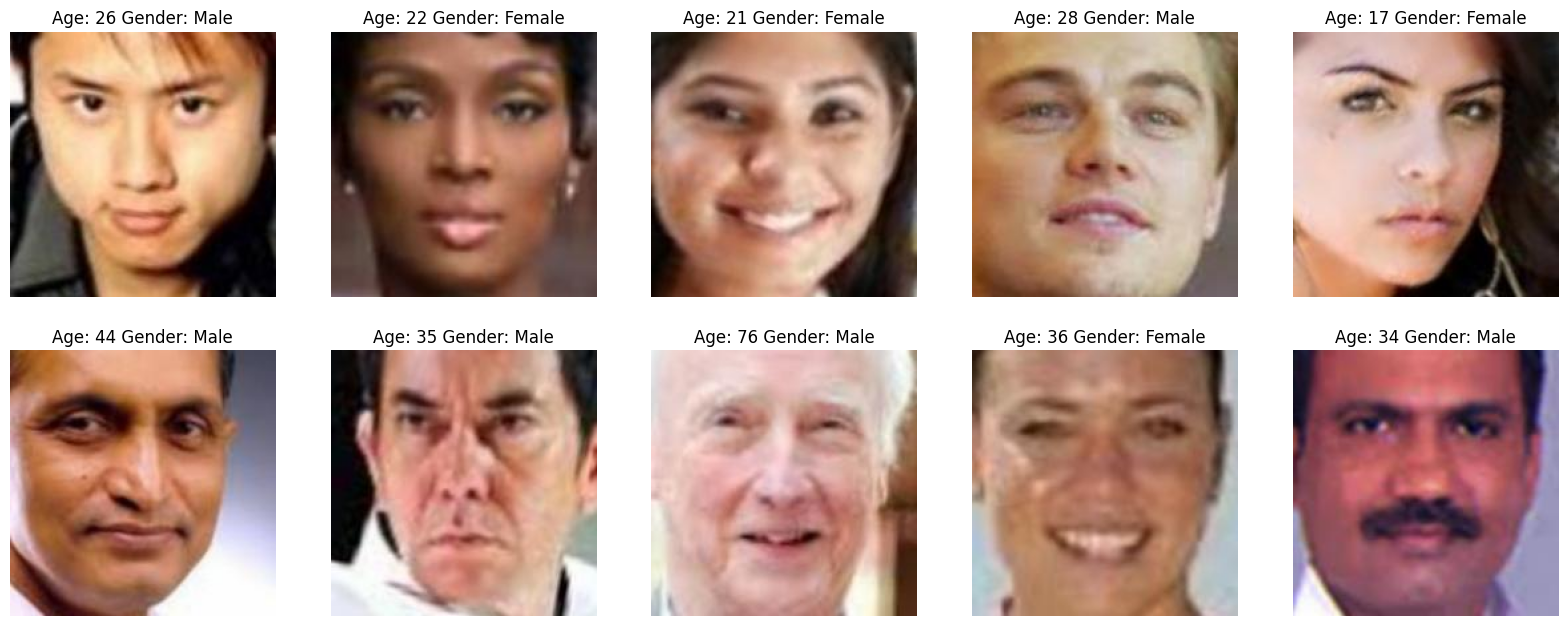

In [29]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:10]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

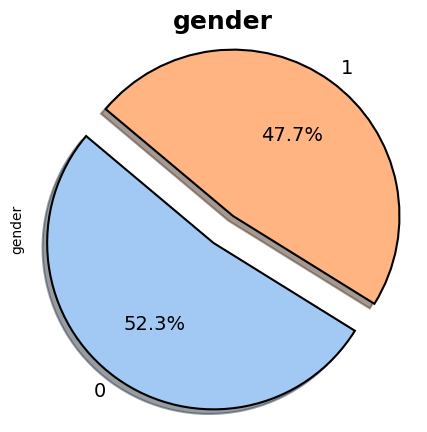

In [30]:
def plot_data(name, data):
    plt.figure(figsize=(5, 5))
    palette_color = sns.color_palette('pastel')
    explode = [0.1 for _ in range(data.nunique())]

    target_counts = df.groupby(name)[name].count()

    target_counts.plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,
    startangle=140,
    textprops={'fontsize': 14},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5} 
    )

    plt.title(name, fontsize=18, weight='bold')
    plt.axis('equal')
    plt.show()


plot_data('gender', df['gender'])

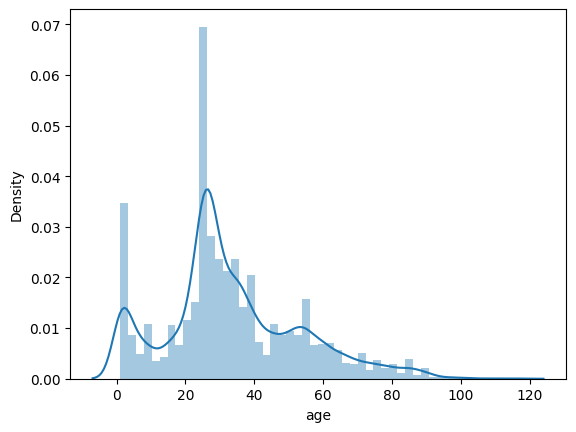

In [31]:
sns.distplot(df['age']);

In [32]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='rgb')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)
    features = np.array(features) / 255.0
    return features

In [33]:
X = extract_features(df['image'])
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

  0%|          | 0/23708 [00:00<?, ?it/s]

# **5-Model Creation**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
create & Compile model
    </font>
</div>

In [34]:
inputs = Input((128, 128, 3))

conv_1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv_1') (inputs)
batch_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(32, 5, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal') (batch_1)
maxp_1 = MaxPooling2D() (conv_2)
dropout_1 = Dropout(0.25) (maxp_1)

flatten = Flatten() (dropout_1)

# fully connected layers
dense_1 = Dense(128, activation = 'relu', kernel_initializer = 'he_normal') (flatten)
dense_2 = Dense(128, activation = 'relu', kernel_initializer = 'he_normal') (flatten)

batch_2 = BatchNormalization() (dense_1)
batch_3 = BatchNormalization() (dense_2)

dropout_2 = Dropout(0.5) (batch_2)
dropout_3 = Dropout(0.5) (batch_3)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_2)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_3)


model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Fit the model
    </font>
</div>

In [35]:
history = model.fit(X, [y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 118s 182ms/step - age_out_mae: 22.9833 - gender_out_accuracy: 0.7520 - loss: 23.5017 - val_age_out_mae: 11.4319 - val_gender_out_accuracy: 0.7680 - val_loss: 11.9071
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 94s 159ms/step - age_out_mae: 10.1864 - gender_out_accuracy: 0.8527 - loss: 10.5257 - val_age_out_mae: 8.5108 - val_gender_out_accuracy: 0.8473 - val_loss: 8.8443
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 94s 158ms/step - age_out_mae: 9.3147 - gender_out_accuracy: 0.8657 - loss: 9.6271 - val_age_out_mae: 9.5914 - val_gender_out_accuracy: 0.8724 - val_loss: 9.8905
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 93s 158ms/step - age_out_mae: 8.8087 - gender_out_accuracy: 0.8842 - loss: 9.0893 - val_age_out_mae: 8.2722 - val_gender_out_accuracy: 0.8728 - val_loss: 8.5604
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 93s 157ms/step - age_out_mae: 8.4877 - gender_out_accuracy: 0.8891 - loss: 8.7516 - val_age_out_mae: 7.7816 - val_gender_out_accuracy: 0.8868 - val_l

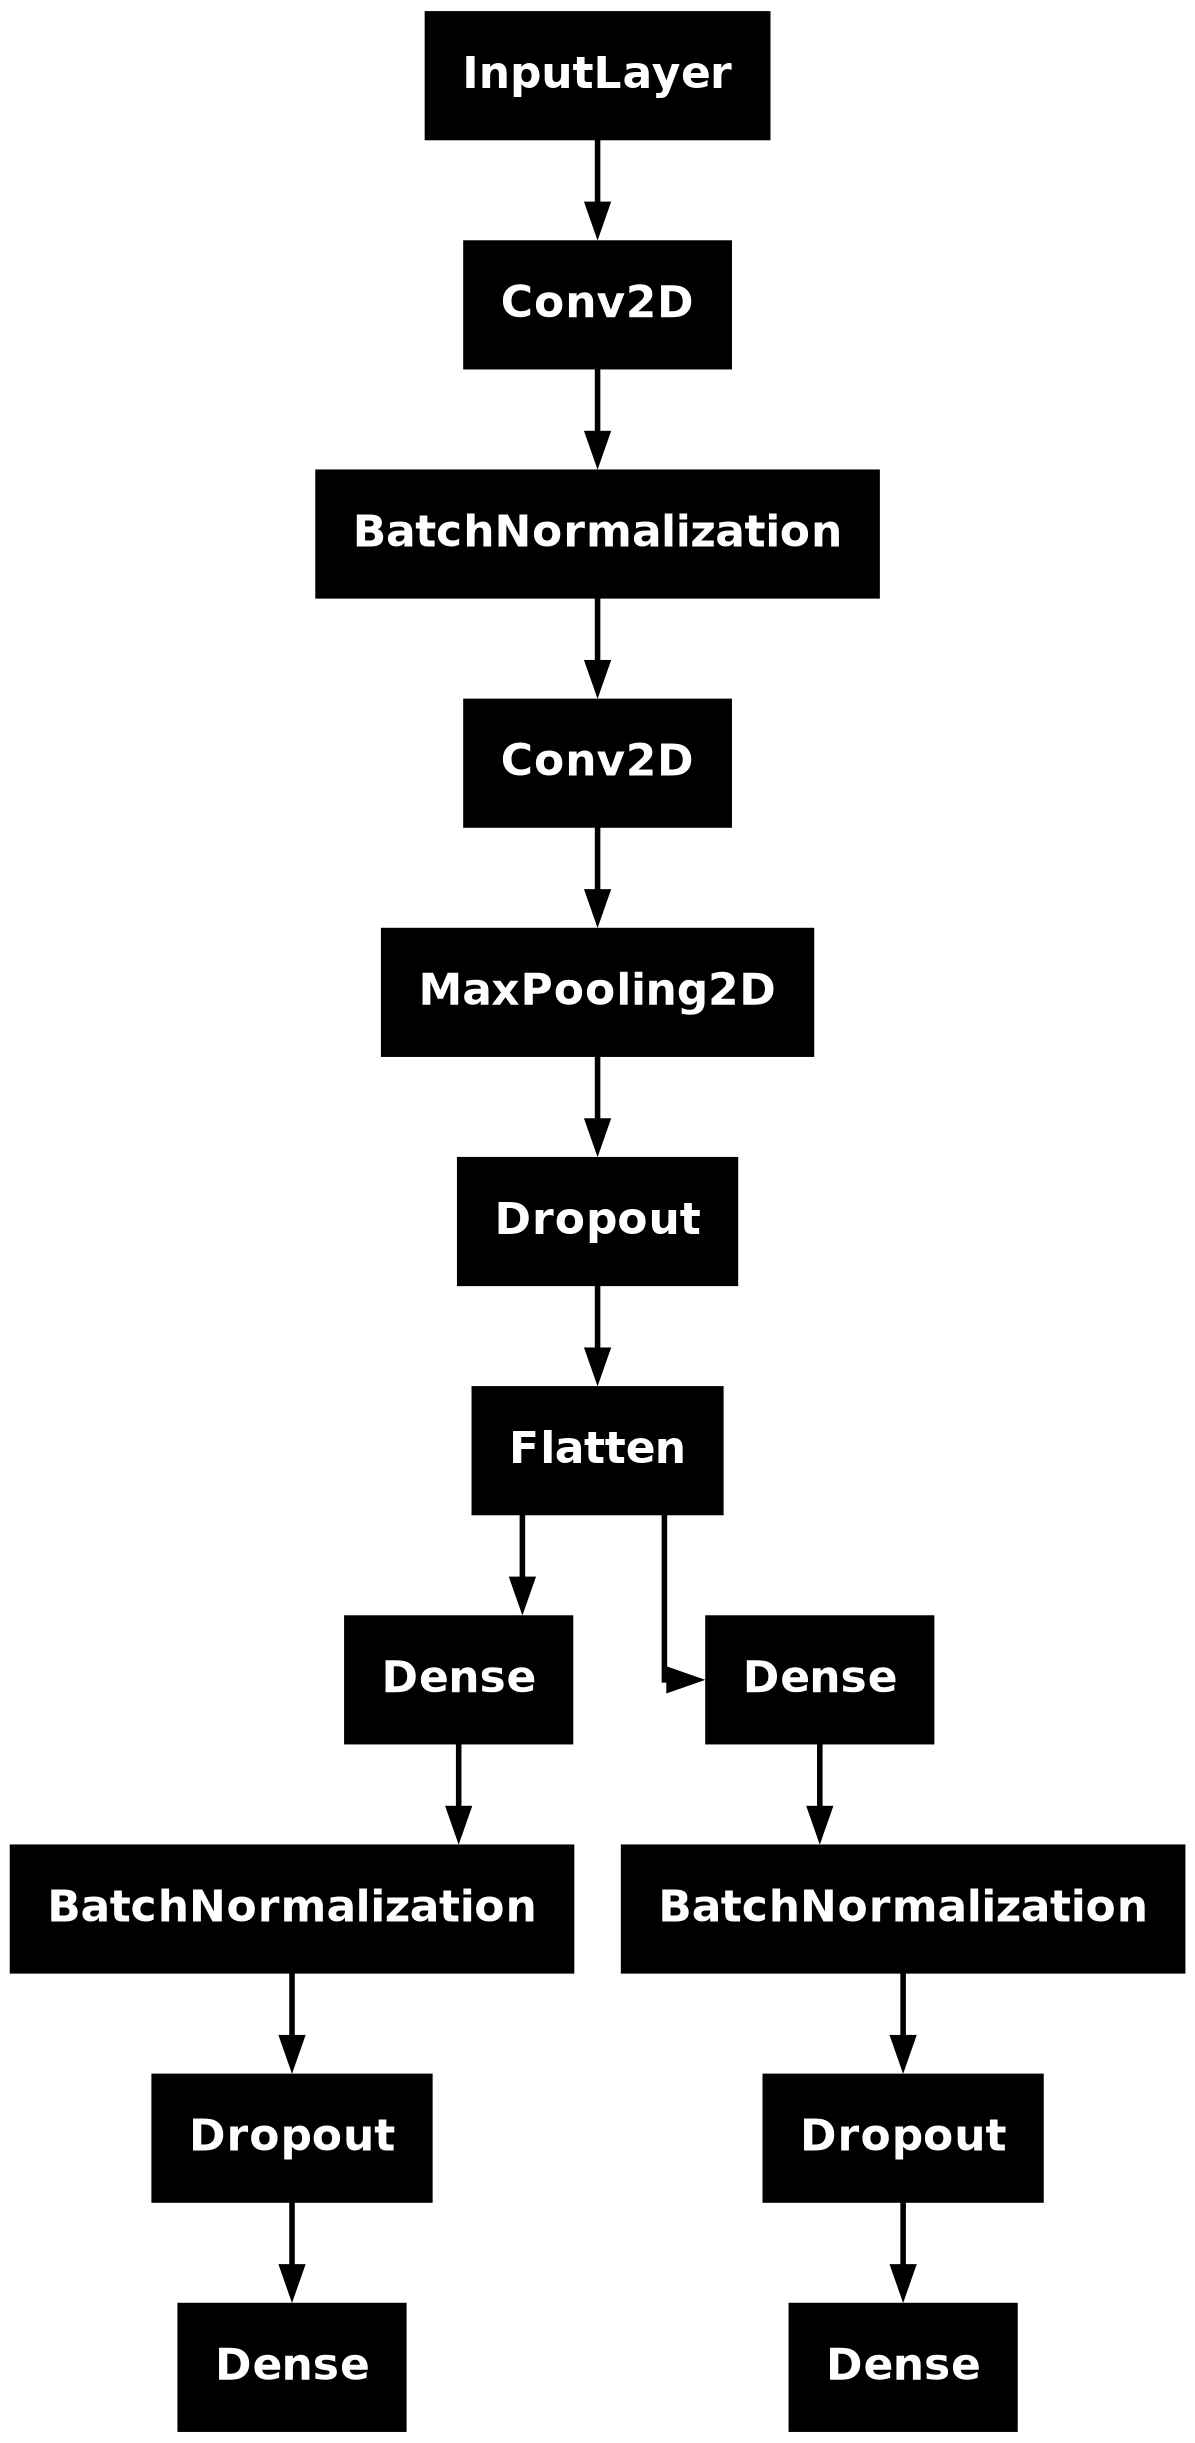

In [36]:
from tensorflow.keras.utils import plot_model
plot_model(model)

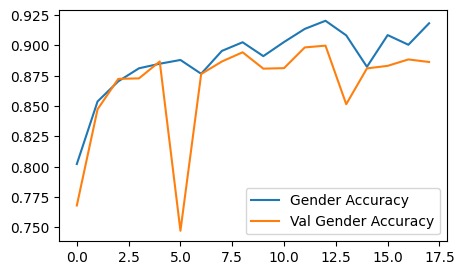

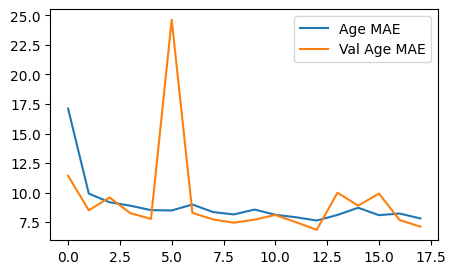

In [37]:
# عرض الرسوم البيانية للأداء
plt.figure(figsize=(5, 3))
plt.plot(history.history['gender_out_accuracy'], label='Gender Accuracy')
plt.plot(history.history['val_gender_out_accuracy'], label='Val Gender Accuracy')
plt.legend()
#plt.title('Gender Accuracy')
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(history.history['age_out_mae'], label='Age MAE')
plt.plot(history.history['val_age_out_mae'], label='Val Age MAE')
plt.legend()
#plt.title('Age MAE')
plt.show()

In [38]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns

149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step


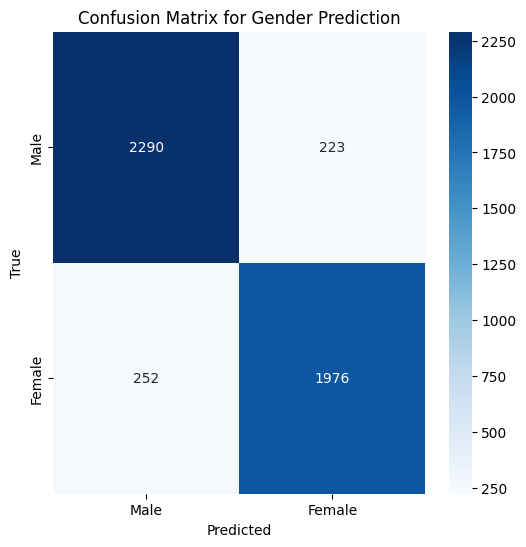

In [41]:
# حساب Confusion Matrix
val_split = int(len(X) * 0.2)
X_val = X[-val_split:]
y_gender_val = y_gender[-val_split:]

pred_gender = model.predict(X_val)[0]
pred_gender = (pred_gender > 0.5).astype(int)

cm = confusion_matrix(y_gender_val, pred_gender)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.title('Confusion Matrix for Gender Prediction')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [40]:
# Save the model (choose one of the options)
model.save('models/custom_CNN.h5')  # HDF5 format
# or
model.save('models/custom_CNN.keras')  # SavedModel format

# Save the history
np.savez('custom_CNN_history.npz', **history.history)

# **6-Plot the Results**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
plot results for gender
    </font>
</div>

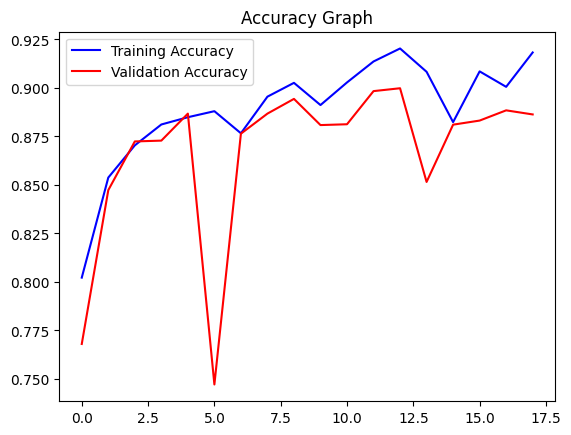

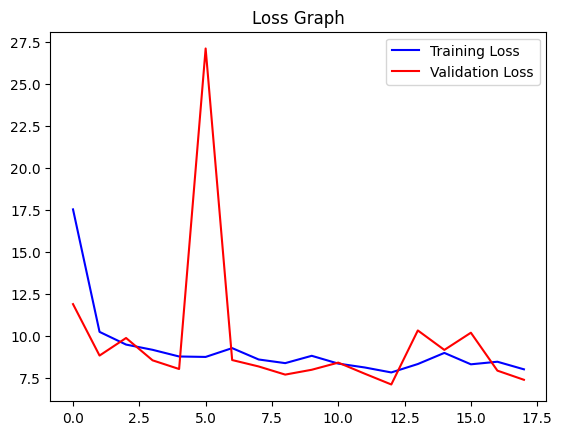

In [42]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
plot results for age
    </font>
</div>

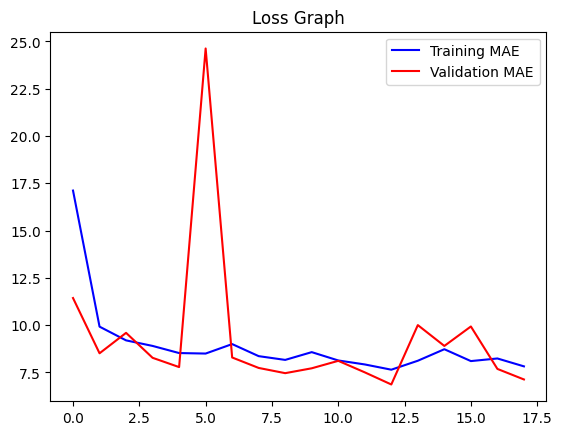

In [43]:
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

# **7-Prediction with Test Data**

In [45]:
image_index = 50
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index])
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 22


ValueError: as_list() is not defined on an unknown TensorShape.

In [ ]:
image_index = 500
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
save model
    </font>
</div>

In [ ]:
# model.save("/kaggle/working/Gender_and_Age.h5")
# model.save("/kaggle/working/Gender_and_Age.keras")